In [1]:
import numpy as np
from scipy import fft
from scipy.interpolate import RegularGridInterpolator
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression


In [2]:
# 1) Load CDM density grid

fgrid = np.load("Grids_Mcdm_IllustrisTNG_1P_128_z=0.0.npy")
rho_cdm = fgrid[14]
Ngrid = rho_cdm.shape[0]
boxsize = 25.0  # Mpc/h

In [3]:
# 2) Cosmology parameters

z_snap = 0.0
a = 1.0 / (1.0 + z_snap)
H0 = 67.66
Omega_m0 = 0.3
Hz = H0 * np.sqrt(Omega_m0 * (1 + z_snap) ** 3 + 1.0 - Omega_m0)
f = (Omega_m0 * (1 + z_snap) ** 3 / (Omega_m0 * (1 + z_snap) ** 3 + 1.0 - Omega_m0)) ** 0.55

In [4]:
# 3) Density contrast and FFT

delta_x = rho_cdm / np.mean(rho_cdm) - 1.0
delta_k = fft.fftn(delta_x)

In [5]:
# k-grid
kfreq = fft.fftfreq(Ngrid, d=boxsize / Ngrid)
kxg, kyg, kzg = np.meshgrid(2 * np.pi * kfreq, 2 * np.pi * kfreq, 2 * np.pi * kfreq, indexing="ij")
k2 = kxg**2 + kyg**2 + kzg**2
k2_nozero = np.where(k2 == 0, 1.0, k2)

In [6]:
# Velocity in k-space
prefactor = 1j * a * Hz * f
vx_k = prefactor * (kxg / k2_nozero) * delta_k
vy_k = prefactor * (kyg / k2_nozero) * delta_k
vz_k = prefactor * (kzg / k2_nozero) * delta_k

vx_k[k2 == 0] = vy_k[k2 == 0] = vz_k[k2 == 0] = 0.0

In [7]:
# Gaussian Smoothing
R_smooth = 2.0  # Mpc/h
W = np.exp(-0.5 * k2 * R_smooth**2)
vx_k *= W
vy_k *= W
vz_k *= W


In [8]:
# Inverse FFT
vx_x = fft.ifftn(vx_k).real
vy_x = fft.ifftn(vy_k).real
vz_x = fft.ifftn(vz_k).real
v_los_recon = vz_x  # LOS along z

print(f"Reconstructed v_los shape: {v_los_recon.shape}")
print(f"v_los range: {v_los_recon.min():.2f} → {v_los_recon.max():.2f} km/s")

#np.save("v_los_reconstructed_IllustrisTNG_1P.npy", v_los_recon)

Reconstructed v_los shape: (128, 128, 128)
v_los range: -257.71 → 244.10 km/s


In [9]:
# 6) Load halo catalog
# -------------------------------
halo_file = "groups_090_1P_p2_n1.hdf5"
mass_keys_candidates = [
    "Group/Group_M_Mean200",
    "Group/GroupMass",
    "Group/Group_M_Crit200",
    "Group/Group_M_Crit500",
    "Group/Group_M_TopHat200"
]

with h5py.File(halo_file, "r") as f:
    group_pos = np.array(f["Group/GroupPos"])  # ckpc/h
    group_vel = np.array(f["Group/GroupVel"])
    # find mass key
    found_key = None
    for key in mass_keys_candidates:
        if key in f:
            found_key = key
            break
    if found_key is None:
        print("Available keys:", list(f["Group"].keys()))
        raise KeyError("No valid mass field found")
    group_mass = np.array(f[found_key]).flatten()

print(f"Loaded {len(group_pos)} halos")


Loaded 21205 halos


In [10]:
# 7) Mass cut (>1e10 M☉/h)

mass_unit = 1e10  # M_sun/h
mass_phys = group_mass * mass_unit
mass_cut = 1e11
mask_mass = mass_phys > mass_cut

group_pos = group_pos[mask_mass]
group_vel = group_vel[mask_mass]
group_mass = group_mass[mask_mass]
mass_phys = mass_phys[mask_mass]

print(f"Number of halos after mass cut (>1e11 M☉/h): {len(group_mass)}")

Number of halos after mass cut (>1e11 M☉/h): 569


In [11]:
# 8) Interpolate reconstructed velocity field
# -------------------------------
group_pos_mpc = (group_pos / 1000.0) % boxsize  # ckpc/h → Mpc/h
cell = boxsize / Ngrid
grid_coords = (np.arange(Ngrid) + 0.5) * cell

interp_func = RegularGridInterpolator(
    (grid_coords, grid_coords, grid_coords),
    v_los_recon,
    bounds_error=False,
    fill_value=np.nan
)
v_los_interp = interp_func(group_pos_mpc)

In [12]:
# 9) True LOS velocity

v_los_true = group_vel[:, 2]  # z-component directly

In [13]:
# 10) Mask invalid

mask = np.isfinite(v_los_interp)
v_true = v_los_true[mask]
v_recon = v_los_interp[mask]
mass_phys = mass_phys[mask]


In [14]:
# 11) Statistics

corr, _ = pearsonr(v_true, v_recon)
bias = np.mean(v_recon - v_true)
rms_true = np.std(v_true)
rms_recon = np.std(v_recon)
rmse = np.sqrt(np.mean((v_recon - v_true) ** 2))
print(f"Matched halos: {mask.sum()}")
print(f"Correlation (ρ) = {corr:.3f}")
print(f"Mean bias = {bias:.3f} km/s")
print(f"RMS true = {rms_true:.3f} km/s, RMS recon = {rms_recon:.3f} km/s")


Matched halos: 560
Correlation (ρ) = 0.857
Mean bias = 0.163 km/s
RMS true = 97.314 km/s, RMS recon = 51.635 km/s


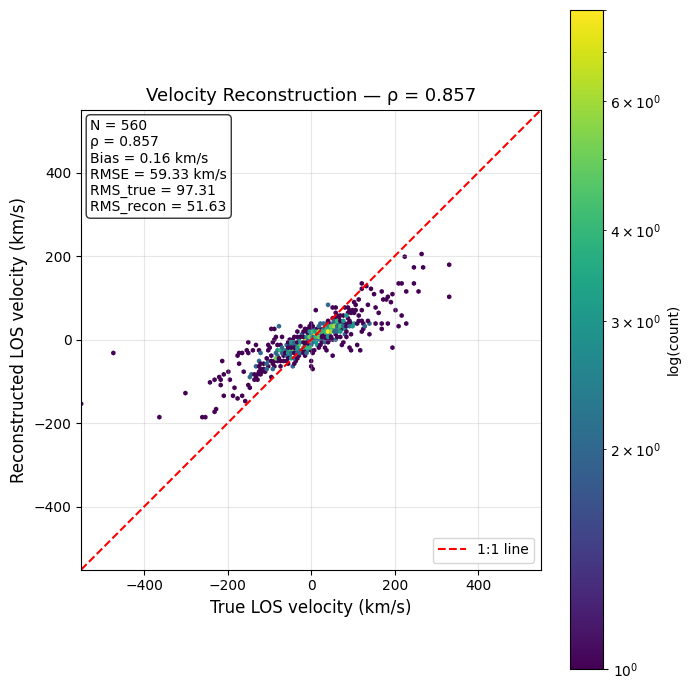

In [15]:
# 12) color-density plot
# -------------------------------
from matplotlib import colors

plt.figure(figsize=(7, 7))
vmax = max(np.max(np.abs(v_true)), np.max(np.abs(v_recon)))
lims = [-vmax, vmax]

# Hexbin 2D density with log color normalization
hb = plt.hexbin(
    v_true, v_recon,
    gridsize=150,
    cmap="viridis",  # similar to paper's blue–green color gradient
    bins='log',
    mincnt=1,
    extent=(lims[0], lims[1], lims[0], lims[1])
)

# 1:1 line
plt.plot(lims, lims, 'r--', lw=1.5, label='1:1 line')

# Equal axes
plt.xlim(lims)
plt.ylim(lims)
plt.gca().set_aspect('equal', adjustable='box')

# Labels and legend
plt.xlabel("True LOS velocity (km/s)", fontsize=12)
plt.ylabel("Reconstructed LOS velocity (km/s)", fontsize=12)
plt.title(f"Velocity Reconstruction — ρ = {corr:.3f}", fontsize=13)
plt.legend(loc="lower right")

# Colorbar
cb = plt.colorbar(hb, label="log(count)")
# Add stats box
text = (
    f"N = {mask.sum()}\n"
    f"ρ = {corr:.3f}\n"
    f"Bias = {bias:.2f} km/s\n"
    f"RMSE = {rmse:.2f} km/s\n"
    f"RMS_true = {rms_true:.2f}\n"
    f"RMS_recon = {rms_recon:.2f}"
)
plt.text(0.02, 0.98, text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle="round", fc="white", alpha=0.8))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("analytical_vel_comp_TNG_1P_p1_n2_z0_for_cnn.jpg", dpi=300)
plt.show()
